In [1]:
from SimPEG import *
import simpegDCIP as DC
%pylab inline
from pymatsolver import MumpsSolver

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
cs = 12.5
nc = 500/cs+1
hx = [(cs,7, -1.3),(cs,nc),(cs,7, 1.3)]
hy = [(cs,7, -1.3),(cs,int(nc/2+1)),(cs,7, 1.3)]
hz = [(cs,7, -1.3),(cs,int(nc/2+1))]

In [3]:
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCN')
print mesh

  ---- 3-D TensorMesh ----  
   x0: -541.97
   y0: -416.97
   z0: -548.22
  nCx: 55
  nCy: 35
  nCz: 28
   hx: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 41*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hy: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hz: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50


In [4]:
sighalf = 1e-2
sigma = np.ones(mesh.nC)*sighalf
p0 = np.r_[-50., 50., -50.]
p1 = np.r_[ 50.,-50., -150.]
blk_ind = Utils.ModelBuilder.getIndecesBlock(p0, p1, mesh.gridCC)
sigma[blk_ind] = 1e-3

In [5]:
nElecs = 21
x_temp = np.linspace(-250, 250, nElecs)
aSpacing = x_temp[1]-x_temp[0]
y_temp = 0.
xyz = Utils.ndgrid(x_temp, np.r_[y_temp], np.r_[0.])

In [6]:
srcList = DC.Examples.WennerArray.getSrcList(nElecs,aSpacing)
survey = DC.SurveyDC(srcList)
print len(survey.srcList)

63


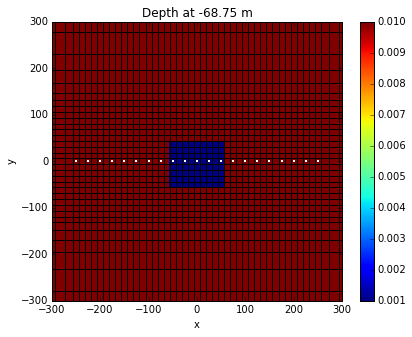

In [7]:
fig, ax = plt.subplots(1,1, figsize = (6.5,5))
indz = 22
dat = mesh.plotSlice(sigma, grid=True, ax = ax, ind=indz)
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)
cb = plt.colorbar(dat[0])
ax.set_title('Depth at '+str(mesh.vectorCCz[indz])+' m')

txLocs = np.array([[tx.loc[0][0], tx.loc[1][0]] for tx in survey.srcList]).flatten()
ax.plot(txLocs, txLocs*0, 'w.', ms = 3)

In [9]:
expmap = Maps.ExpMap(mesh)
m2to3  = Maps.Map2Dto3D(mesh,normal='Y')
imap   = Maps.IdentityMap(mesh)
problem = DC.ProblemDC_CC(mesh, mapping= imap )
problem.Solver = MumpsSolver
problem.pair(survey)

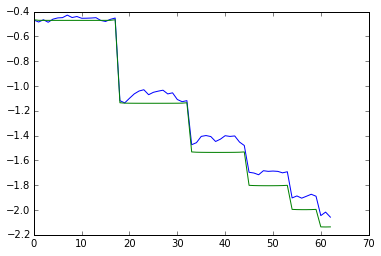

In [10]:
datasyn = survey.dpred(sighalf*np.ones(mesh.nC))
survey.makeSyntheticData(sigma,std=0.01,force=True)
plot(np.log(np.c_[survey.dobs,datasyn]))

In [11]:
problem.mapping = expmap * m2to3

In [12]:
dmis = DataMisfit.l2_DataMisfit(survey)
reg = Regularization.Tikhonov(mesh,mapping=m2to3)
opt = Optimization.InexactGaussNewton(maxIter=7,tolX=1e-15)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1e1)
betaSched = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaSched])

In [13]:
m0 = np.log(np.ones(problem.mapping.nP)*sighalf)
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  7.28e+00  1.86e+03  1.05e+04  7.84e+04    2.20e+03      0              
   1  7.28e+00  6.57e+02  1.06e+04  7.80e+04    1.15e+03      1              
   2  1.46e+00  5.58e+02  1.06e+04  1.61e+04    1.03e+03      3   Skip BFGS  
   3  1.46e+00  1.36e+02  1.08e+04  1.59e+04    1.69e+02      0   Skip BFGS  
   4  2.91e-01  8.24e+01  1.07e+04  3.20e+03    2.05e+02      0              
   5  2.91e-01  4.61e+01  1.07e+04  3.16e+03    1.35e+02      0   Skip BFGS  
   6  5.83e-02  4.40e+01  1.07e+04  6.65e+02    1

<matplotlib.colorbar.Colorbar instance at 0x10fcbaa28>

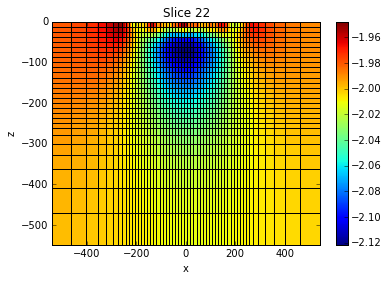

In [14]:
colorbar(mesh.plotSlice(np.log10(expmap * m2to3 * mopt), normal='Y', ind=indz, grid=True)[0])

In [15]:
dpred = survey.dpred(mopt)

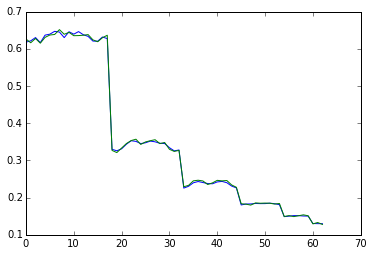

In [16]:
plot(np.c_[dpred,survey.dobs])